In [1]:
%config IPCompleter.greedy=True

# Social Recommendation Systems (CiaoDVD Dataset)

## Goal
The aim of this project is to build a tool that implements and compares different types of recommendation algorithms on a real-world dataset. The tool should be able to: 
- Load the dataset 
- Run different recommendation algorithms on the dataset 
- Compare and discuss the results, parameter sensitivity

### Task 1. Load the dataset
- Load the CiaoDVD dataset from https://www.librec.net/datasets.html
- Explore the properties of the graph

#### This initial section contais the modules and dependencies required to run the code
- Customized fucntions to plot [plots.py](plots.py)
- Split dataset between train and test data with sklearn [splitData.py](splitData.py)
- RMSE and MAE functions [metrics.py](metrics.py)
- Weigth-Centralilized normalization for prediction [prediction.py](prediction.py)

In [2]:
# Import all the modules and dependencies required 
import pandas as pd
import numpy as np
import warnings
import logging

# Widgets for graphical interface
import ipywidgets as widgets
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, clear_output

import plots
import splitData
import metrics
import prediction as pred

# Used to get multiple outputs per cell
InteractiveShell.ast_node_interactivity = "all"

warnings.filterwarnings("ignore")  # ignore warnings in logs

logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO) 

#### Loading Dataset

In [3]:
# Loading Dataset
headers = ['userId', 'movieId', 'movie_categoryId', 'reviewId', 'movieRating', 'reviewDate']
columns = ['userId', 'movieId', 'movie_categoryId', 'movieRating']
dataset = pd.read_csv('Dataset/movie-ratings.txt',
                           names=headers, usecols=columns, dtype={'userId': 'str', 'movieId': 'str', 'movie_categoryId':'str'})
# Dataset information
print('Dataset information')
num_users = dataset.userId.unique().shape[0]
num_items = dataset.movieId.unique().shape[0]
num_cat = dataset.movie_categoryId.unique().shape[0]
sparsity = 1 - len(dataset) / (num_users * num_items)
print(f"Users: {num_users}\nMovies: {num_items}\nCategories: {num_cat}\nSparsity: {sparsity}")
dataset.info()
dataset.describe()

Dataset information
Users: 17615
Movies: 16121
Categories: 17
Sparsity: 0.9997441115684126
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72665 entries, 0 to 72664
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   userId            72665 non-null  object
 1   movieId           72665 non-null  object
 2   movie_categoryId  72665 non-null  object
 3   movieRating       72665 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.2+ MB


,movieRating
count,72665.000000
mean,4.072910
std,1.081442
min,1.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,5.000000


#### Movie categories analysis

,count,mean,std,min,25%,50%,75%,max
movieRating,17.0,4.154724,0.246792,3.555667,4.02443,4.171916,4.295187,4.557371



Ratings per category


,movieRating,ratings_per_category
movie_categoryId,,
16,4.058542,14639
13,4.024159,12128
14,4.121325,12075
17,3.555667,6952
15,4.557371,5447


,movieRating,ratings_per_category
movie_categoryId,,
5,4.380000,350
2,4.090032,311
10,4.264228,246


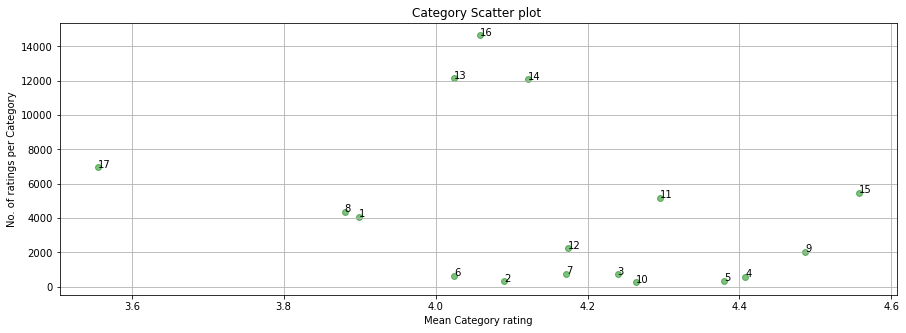

In [4]:
#dataset.groupby('movie_categoryId')['movieId'].count().sort_values(ascending=False)
#dataset.groupby('movie_categoryId')['movieRating'].mean().sort_values(ascending=False)
# average categorie ratings
categories = pd.DataFrame(dataset.groupby('movie_categoryId')['movieRating'].mean())

categories.describe().T

# quantity of movies per categorie
categories['ratings_per_category'] = dataset.groupby('movie_categoryId')['movieId'].count()

# sorted by number of categories
print('\nRatings per category')
categories.sort_values('ratings_per_category', ascending=False).head()
categories.sort_values('ratings_per_category', ascending=False).tail(3)

# Plot number of movies per categories
plot_settings = {
    'axisX':'movieRating', 
    'axisY': 'ratings_per_category', 
    'topic': 'Category', 
    'color':'green',
    'labels': categories.index}
plots.scatterPlot(categories, plot_settings)

#### Rating Analysis

,count,mean,std,min,25%,50%,75%,max
movieRating,16121.0,3.904244,1.000072,1.0,3.2,4.0,4.8,5.0



Ratings per Movie


,movieRating,ratings_per_movie
movieId,,
6119,4.662818,433
6068,3.838120,383
12105,4.360269,297
7584,4.658120,234
6159,4.705628,231


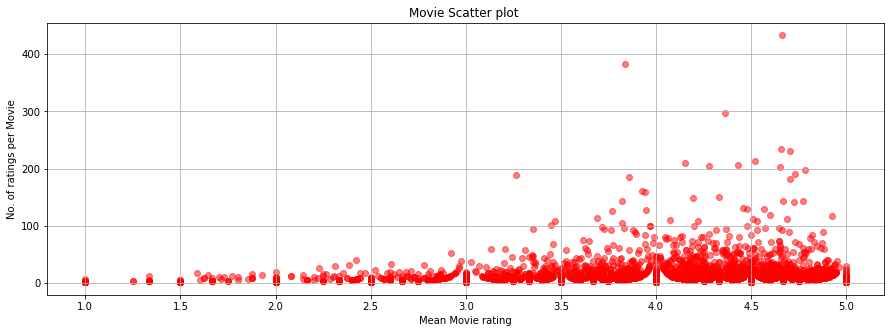

In [5]:
# average rating for each movie
ratings = pd.DataFrame(dataset.groupby('movieId')['movieRating'].mean())

ratings.describe().T

# quantity of ratings per movie
ratings['ratings_per_movie'] = dataset.groupby('movieId')['movieRating'].count()

# sorted by number of ratings
print('\nRatings per Movie')
ratings.sort_values('ratings_per_movie', ascending=False).head()

# Plot number of movies per rating
plot_settings = {
    'axisX':'movieRating', 
    'axisY': 'ratings_per_movie', 
    'topic': 'Movie'}
plots.scatterPlot(ratings, plot_settings)

#### Split the dataset in training and testing data

In [6]:
# Split the Dataset in train 80% and test 20%
train_data, test_data = splitData.split_train_test(dataset, 0.2)

# From here the train_data is the dataset to make the computings
# and test_data is only for measures after the results
print('Train Dataset')
train_data
print('\nTest Dataset')
test_data

Train Dataset


userId,1,10,100,1000,10000,10002,10003,10004,10005,10006,...,9987,9988,9989,999,9993,9994,9995,9996,9998,9999
movieId,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Test Dataset


userId,1,10,100,1000,10001,10002,10005,10009,10011,10013,...,9974,998,9981,999,9990,9991,9992,9994,9995,9997
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### User ratings average values

User ratings avg.


userId
1        4.000000
10       4.333333
100      3.346154
1000     4.000000
10000    5.000000
           ...   
9994     4.666667
9995     4.800000
9996     4.500000
9998     5.000000
9999     5.000000
Length: 15416, dtype: float64

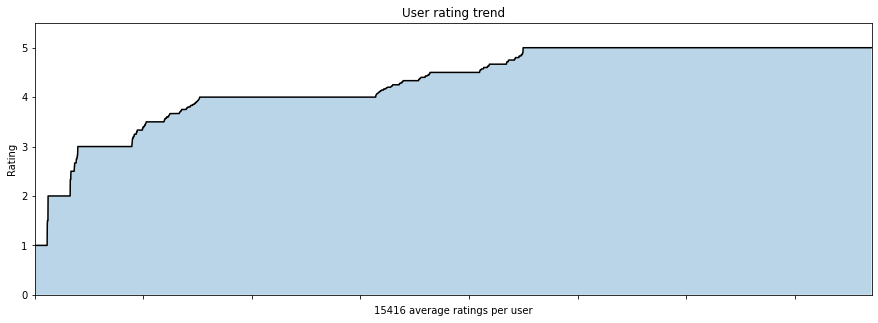

In [7]:
# We get the average of all the movie ratings for each user
user_mean = train_data.mean(axis=0, skipna=True)
# Print the user ratings mean value
print('User ratings avg.')
user_mean

# Plot number of movies per rating
plots.avg_ratings_per_user(user_mean)

## User based Collaborative Filtering Recommender with pearson correlation coefficient

### Similarity section
#### Pearson correlation coeficient
![alt text](Images/pearson_corr.png "Pearson Correlation")

In [8]:
def get_pearson_correlation(data_set, user):
    # The high correlation coefficients are the users that are most similar to target user
    # Pearson correlation coefficient: this will lie between -1 and 1
    pearson_corr = data_set.corrwith(data_set[user], method='pearson')
    
    # Here below the pearson correlation computation from scratch is commented because 
    # the performance is lower than the pandas's corrwith method used above
    """
    pearson_corr = pd.DataFrame(columns = movie_matrix.columns)
    for i in movie_matrix.columns:
        user_1 = movie_matrix[user][:]
        user_2 = movie_matrix[i][:]
        nans = ~np.logical_or(np.isnan(user_1), np.isnan(user_2))
        user_1 = np.compress(nans.values, user_1.values)
        user_2 = np.compress(nans.values, user_2.values)
        
        # Numerator 
        user1_product = user_1 - user_1.mean()
        user2_product = user_2 - user_2.mean()
        top = (user1_product*user2_product).sum()
        
        # Denominator 
        user1_sqr = np.sqrt((user1_product**2).sum())
        user2_sqr = np.sqrt((user2_product**2).sum())
        bottom = user1_sqr * user2_sqr
        
        correl = top/bottom
        pearson_corr[i] = [correl]"""
    return pearson_corr

### Neighborhood section
#### Selection of neighbors based on k size and threshold
- Neighbors correlation
- Neighbors's ratings
- Average ratings
- User target average

In [9]:
# The k similar users for target user, the highest the correlation value, the more similar.
def get_neighborhood(data_set, pearson_corr, user, k, threshold):
    a = np.arange(start=0, stop=len(data_set), step=1)
    df = pd.DataFrame(columns=a)
    df = df.append(pd.Series(), ignore_index=True).T
    
    # Sort the correlation vector in descending way, to get the most similar at first
    corr_top = pearson_corr.sort_values(ascending=False)
    
    # Neighborhood selection: Based on Threshold and the most similar users
    if len(corr_top) > 0:
        top = set(corr_top[(corr_top.iloc[0:] < threshold)].index.values)
        top.add(user)
        # Drop the user target itself and the users under the threshold
        corr_top = corr_top.drop(top)[:k].to_frame().T
    else:    
        return (df)  # if there is not neighbors or the correlation is nan return a vector of nan

     # Validate if the correlation for the target user is Null or is only the user itself
    if(corr_top.isnull().values.all()):
        return (df)
    
    # This list is basically to select the rating of the k users
    corr_labels = corr_top.columns.tolist()
    # Here we are using the previous list to select the ratings
    rating_top = data_set.loc[:, corr_labels]

    # Taking the average ratings only for the top k neighbors
    mean_top = user_mean[corr_labels]

    # Taking the average rating for the target user
    ru_mean = user_mean[user]
    
    
    return (corr_top, rating_top, mean_top, ru_mean)

### Prediction section

#### Mean-Centering normalization 
![alt text](Images/prediction.png "Mean-Centering Normalization")

In [10]:
def get_prediction(user, corr_top, rating_top, mean_top, ru_mean, k):    
    # This list is basically to select the rating of the k users
    corr_labels = corr_top.columns.tolist()
    
    prediction_results = pd.DataFrame()
    # We iterate over the rows of the top k similar users ratings
    for item, row in rating_top.iterrows():
        # Getting the rating values for the movies of each user of the top 
        ratings_row = row[corr_labels].values
        # Computing the prediction values, using the normalized model. We call this function sending as parameters
        # the correlation values of the k users and the ratings they have assigned to the items
        pred_value = pred.prediction_normalized(corr_top, ratings_row, k, mean_top, ru_mean)

        # limit the results to the min and max bounds rating range
        pred_value = 1 if pred_value < 1 else (5 if pred_value > 5 else pred_value)

        prediction_results = prediction_results.append(pd.Series({user: round(pred_value, 2)}, name=item))
    return prediction_results

### Main function

In [11]:
def main(k, threshold):
    # Prediction matrix
    prediction_matrix = pd.DataFrame(index=train_data.index)
    for current_user in current_users:
        logging.info(f"Getting prediction for user {current_user}")
        pearson_corr = get_pearson_correlation(train_data, current_user)
        neighborhood = get_neighborhood(train_data, pearson_corr, current_user, k.value, threshold.value)
        if(~neighborhood[0].isnull().values.all()):
            prediction_matrix[current_user] = get_prediction(current_user, neighborhood[0], neighborhood[1], neighborhood[2], neighborhood[3], k.value)
        else:
            prediction_matrix[current_user] = neighborhood.values
    
    return prediction_matrix.sort_index(axis=1)

## Testing

### Root Mean Square Error (RSME) and Mean Absolute Error (MAE) 
![alt text](Images/rmse.png "Root Mean Square Error") ![alt text](Images/mae.png "Mean Absolute Error")

In [12]:
# Computing the rmse and mae between predicted_data and test_data
def get_metrics(prediction_matrix):
    logging.info(f"Getting RMSE")
    rmse_value = metrics.rmse(test_data, prediction_matrix)
    logging.info(f"Getting MAE")
    mae_value = metrics.mae(test_data, prediction_matrix)
    return rmse_value, mae_value

#### Random selection of users

In [13]:
import random

def get_random_users(q):
    users = set(test_data.columns.intersection(train_data.columns).values)
    number_of_users = len(users)
    samples = random.sample(users, q)
    return samples, number_of_users

##### Below is possible to set the number of users randomly selected to compute the prediction

In [14]:
# Insert number of users, that will be selected randomly from posible target users 
q_user = widgets.BoundedIntText(value=1, min=1, max=10, step=1, description='No. users:', disabled=False)

current_users = []

# The function to interact in real time
def random_user(x = 1):
    clear_output()
    global current_users
    current_users, number_of_users = get_random_users(q_user.value)
    q_user.max = number_of_users
    display(pd.DataFrame(current_users).T)

widgets.interact(random_user, x = q_user)

interactive(children=(BoundedIntText(value=1, description='No. users:', max=10, min=1), Output()), _dom_classe…

<function __main__.random_user(x=1)>

#### Setting global variables

In [15]:
# The number of neighbors for the prediction
k = widgets.BoundedIntText(value=1, min=1, step=1, description= 'k size: ', disabled= False)
# Value used for neighborhood selection
threshold = widgets.FloatSlider(value= 0, min= -1, max= 1, step=0.01, description= 'Threshold: ')
# Button to start computing
button = widgets.Button(description='Run')
output = widgets.Output()


rmse = widgets.FloatText(description= 'RMSE: ', disabled= True)
mae = widgets.FloatText(description= 'MAE: ', disabled= True)

def on_button_clicked(b):
    with output:
        clear_output()
        prediction_matrix = main(k, threshold)
        rmse.value, mae.value = get_metrics(prediction_matrix)
        
        # Only for visual verification
        small_pred = prediction_matrix.dropna(axis=1, how='all').dropna(how='all')
        
        display(widgets.Label(value="Predicted Matrix"), small_pred)  
        display(widgets.Label(value="Test Matrix"), test_data.loc[:, small_pred.columns].dropna(how='all'))
        print('Done!')
button.on_click(on_button_clicked)

# Widgets interface
widgets.Label(value="Results")
rmse
mae

k
threshold
display(button, output)

Label(value='Results')

FloatText(value=0.0, description='RMSE: ', disabled=True)

FloatText(value=0.0, description='MAE: ', disabled=True)

BoundedIntText(value=1, description='k size: ', min=1)

FloatSlider(value=0.0, description='Threshold: ', max=1.0, min=-1.0, step=0.01)

Button(description='Run', style=ButtonStyle())

Output()